In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-28 18:40:17.146 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]

2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [7]:
import collections
count_labels = collections.Counter([traindataset[i][1] for  i in range(len(traindataset))])
{v: count_labels[v] / len(traindataset) for v in count_labels}
# TODO ~ about 4 lines of code

{'humor': 0.31414510476474533,
 'wiki': 0.31175900380284843,
 'proverbs': 0.06196405935426143,
 'reuters': 0.3121318320781448}

Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

Naar voren komt is dat de dataset ongebalanceerd is. De verdeling van de 4 classes is niet gelijk. Het aantal zinnen met het label 'proverbs' is beduidend lager vergeleken met de andere 3 labels. De kans dat het de zin het label 'humor' of 'wiki'of 'reuters' heeft is veel groter. Het model kan hierdoor niet bruikbare features leren van de groep met het label 'proverbs'. Er is hierdoor een vergrote kans van overfitting.      

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [8]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    "A preprocessor with the cast_label function for adding the labels from the dictionary"
    def cast_label(self, label: str) -> int:
        if label in d.keys():
            return d[label]

To test the preprocessor:

In [10]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])

(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [11]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [12]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 31]),
 tensor([1, 1, 0, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 0, 0,
         2, 2, 0, 2, 0, 0, 0, 1]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [13]:
from src.models import metrics
import torch
# TODO ~ 2 lines of code

metrics = [metrics.Accuracy()]
loss_fn = torch.nn.CrossEntropyLoss()


Om te controleren of de uitkomst correct is gebruiken we de CrossEntropyloss. Deze is geschikt voor multiclass categorisatie. MSE kan bijvoorbeeld hier niet voor gebruiken aangezien dit juist is voor numerieke voorspellingen. 
De f1 score kijkt naar een gemiddele van de precisie en recall ( tussen 0 en 1) scores en kan worden gebruikt voor classificatie problemen. Deze wordt verder in het notebook toegevoegd, hierbij zie je namelijk ook een verandering van de confusion matrix. De F1 score kan gebruikt worden in ongebalanceerde datasets. 
MASE en MAE kunnen niet worden gebruikt i.v.m. classificatie probleem ?? Check. 


## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [27]:

log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3, # check num_layers
    "dropout": 0.1, # check dropout
    "output_size": 4,
}
from src.models import rnn
model = rnn.NLPmodel(config)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [15]:
len(traindataset)/32 # lengte traindataset gedeeld door de batchsize

419.09375

De lengte van de traindataset is 13.411. Hierbij kun je dus 420 batches maken van 32. 

In [16]:
(len(traindataset) + len(testdataset)) / (32*25) # later nog checken

20.955

De totale dataset heeft een lengte van 16.764. Om de hele datsaet te covereren zijn er 21 epochs nodig. Zijn eigenlijk dan 17 epoch niet voldoende ( zie train en dataloade langs elkaar). Check!!!

In [17]:
len(traindataset) / (32*25)

16.76375

Om de totale triandatset te coveren zijn er mnimaal 17 epochs nodig op baiss van 25 train_steps.  

In [33]:
from src.training import train_model

model = train_model.trainloop(
    epochs=21,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-06-27 10:34:08.011 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220627-1034
100%|██████████| 25/25 [00:04<00:00,  5.96it/s]
2022-06-27 10:34:13.328 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.3342 test 1.2710 metric ['0.3162']
100%|██████████| 25/25 [00:03<00:00,  6.71it/s]
2022-06-27 10:34:17.955 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2727 test 1.2295 metric ['0.3675']
100%|██████████| 25/25 [00:02<00:00, 10.23it/s]
2022-06-27 10:34:21.000 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 1.2420 test 1.2283 metric ['0.3275']
100%|██████████| 25/25 [00:01<00:00, 13.64it/s]
2022-06-27 10:34:23.458 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 1.0918 test 0.9830 metric ['0.5687']
100%|██████████| 25/25 [00:02<00:00, 10.67it/s]
2022-06-27 10:34:26.504 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train 0.9370 test 0.9132 metric ['0.5350']
10

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

your explanation here

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

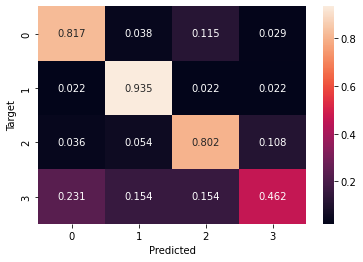

In [34]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

Je ziet hier de uitkomst tussen niet normale verdeling van de dataset. HIerbij is bijvoorbeeld de eerste cel, deze is predicted 0 en voor 96% is deze ook 0. Dit geldt dus niet voor groep 3, waarbij deze maar 48% ook groep 3 voorspelt. Label 3 is de groep 'proverbs, waarbij er een veel lager aantal van is.  Mogleijk datamodificeren zodat er meer data van die groep binnenkomt. Geen data weggooien. Misschien meer gewicht meegen aan de groep. De dataset is dus ongebalanceerd. Een mogelijkheid hiervoor is om data augmenting te gebruiken. Hierbij gaan we dus de data kunstmatig vergroten van de group 'proverbs'. Hierbij kun je meer gewicht toekennen aan de groep 'proverbers'. Dit zal invloed hebben op de likelihood dat een punt uit een klasse wordt getrokken, doordat je van een uniforme verdeling naar een multinomiale verdeling met gecontroleerde paremeters gaat. De F1Score zorgt ook voor een betere verhouding. Deze wordt toegevoegd aan de metrics en nogmaals wordt de confusion matrix uitgedraaid.    
 

In [19]:
from src.models import metrics
metrics = [metrics.Accuracy(), metrics.F1Score()]


In [36]:
from src.training import train_model

model = train_model.trainloop(
    epochs=21,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-06-27 10:35:49.918 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220627-1035
100%|██████████| 25/25 [00:05<00:00,  4.30it/s]
2022-06-27 10:35:56.843 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 0.3135 test 0.4547 metric ['0.8425', '0.7374']
100%|██████████| 25/25 [00:03<00:00,  7.73it/s]
2022-06-27 10:36:00.930 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 0.3201 test 0.4000 metric ['0.8475', '0.7491']
100%|██████████| 25/25 [00:01<00:00, 13.04it/s]
2022-06-27 10:36:03.339 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.3073 test 0.3324 metric ['0.8875', '0.7798']
100%|██████████| 25/25 [00:02<00:00, 10.60it/s]
2022-06-27 10:36:06.536 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.2691 test 0.3859 metric ['0.8738', '0.8199']
100%|██████████| 25/25 [00:02<00:00,  9.85it/s]
2022-06-27 10:36:09.869 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

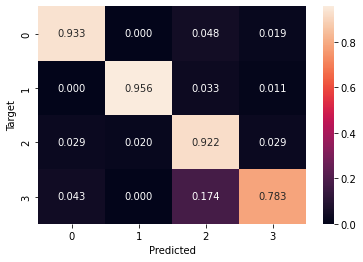

In [40]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Hierbij komt naar voren dat voor dat voor target 3 in ~75% van de gevallen als een 3 wordt voorspeld. Dit is beduidend hoger dan alleen gebruik te maken van de accurcy metric.

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

In [ ]:
#filter groter maken, le groter maken ( is nu vrij klein) 

Hierbij hebben we een nieuwe class toegevoegd in de rnn models. Dit is de AttentionNLP > hierbij zit dus een attional layer tussen de GRU en linear. Dit zorgt voor meer context in het verhaal. In eerste instantie worden de huidige parameters ingesteld, hierbij wel de toevoeging van de F1 score.  

In [20]:
model = rnn.AttentionNLP(config)

20220625-0936 zonder attention layer
20220625-0938 met attenlion layer. Zorg voor lagere loss en hogere accurcy. 
Nog to do learnin grate spelen en trains steps. 

test op meer filters om 12:05 > zorgt mogelijk over overfitting > telkens copies maken. Met meer filters wel hogere accurcy direct in het begin (20220625-0957). Filters verhogen naar 1024 (20220626-1115). Check hierna ook de confusion matrix. 

In [39]:
from src.training import train_model

model = train_model.trainloop(
    epochs=21,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-06-27 10:37:00.449 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220627-1037
100%|██████████| 25/25 [00:04<00:00,  5.40it/s]
2022-06-27 10:37:06.209 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.1913 test 1.1768 metric ['0.4625', '0.3238']
100%|██████████| 25/25 [00:03<00:00,  7.89it/s]
2022-06-27 10:37:09.973 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.0034 test 0.9234 metric ['0.7063', '0.5576']
100%|██████████| 25/25 [00:02<00:00, 11.75it/s]
2022-06-27 10:37:12.768 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.8046 test 0.6714 metric ['0.7650', '0.6072']
100%|██████████| 25/25 [00:02<00:00, 10.65it/s]
2022-06-27 10:37:15.808 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.7855 test 0.6571 metric ['0.7612', '0.6294']
100%|██████████| 25/25 [00:02<00:00, 10.79it/s]
2022-06-27 10:37:18.735 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

Het model met de attention zorgt voor een lagere loss en een hogere accuracy. De learning rate en de optizmier zijn erg afhankelijk van elkaar. De Adam optimzier stop niet direct bij een mogelijk laag punt, maar kijkt verder. Je ziet op het tensorboard dat de learning rate bij de attention layer nog stabiel blijft ondanks er een scheduler in het model zit (Check). Om deze reden wordt eerst het aantal epoch opgehoogd (36). Dit zorgt ook voor een verbetering > zie 20220627-1052 with epochs 36. Meer hidden layersx zorge niet zozeer voor een verbetering van het model (check waarom). Controle aantal trainings steps groter dan batchsize. 

 veel train_ steps kan leiden tot overfitting > zie test loss. Te hoge learning rate geeft juist een verslechtering van de accuracy. Een te lage le ( bv le4 ) geeft juist een hoge loss. 
 

Te

In [32]:
from src.training import train_model

model = train_model.trainloop(
    epochs=36,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-06-28 19:24:48.984 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220628-1924
100%|██████████| 25/25 [00:03<00:00,  6.85it/s]
2022-06-28 19:24:53.810 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.8208 test 1.8129 metric ['0.3575', '0.2941']
100%|██████████| 25/25 [00:02<00:00,  8.94it/s]
2022-06-28 19:24:57.189 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.8740 test 1.8595 metric ['0.3488', '0.2778']
100%|██████████| 25/25 [00:03<00:00,  7.91it/s]
2022-06-28 19:25:01.244 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 1.8621 test 1.9691 metric ['0.3075', '0.2450']
100%|██████████| 25/25 [00:02<00:00,  9.74it/s]
2022-06-28 19:25:04.500 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 1.8646 test 1.8526 metric ['0.3463', '0.2682']
100%|██████████| 25/25 [00:02<00:00, 11.45it/s]
2022-06-28 19:25:07.299 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train